# Task 1: Knowledge Graphs
## 1.1 AFIB dataset

#### 1.1.0 Install and import libraries

In [ ]:
!pip install torch-geometric -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install rdflib

Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.6 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as pyg_nn
import matplotlib.pyplot as plt

#### 1.1.1 Data exploration

Explore the data. We found that node features for AFIB is missing

In [ ]:
from torch_geometric.datasets import Entities
from torch_geometric.utils import to_networkx

dataset = Entities('data/Entities', 'AIFB')
data = dataset[0]
print(f'Dataset: {dataset}')
print(f'Data: {data}\n')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of relations: {dataset.num_relations}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

# Calculating diameters is very time-consuming......
G = to_networkx(data, to_undirected=True)
connected_components = list(nx.connected_components(G))
diameters = []
for i, component in enumerate(connected_components):
    subgraph = G.subgraph(component)
    diameters.append(nx.diameter(subgraph))
print(f"Diameter: {max(diameters)} \n")

print(f'Node features: {data.x}')

Extracting data/Entities/aifb.tgz
Processing...
Done!


Dataset: AIFBEntities()
Data: Data(edge_index=[2, 58086], edge_type=[58086], train_idx=[140], train_y=[140], test_idx=[36], test_y=[36], num_nodes=8285)

Number of nodes: 8285
Number of edges: 58086
Number of features: 0
Number of classes: 4
Number of relations: 90
Average node degree: 7.01
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
Diameter: 8 

Node features: None


Visualize the data:

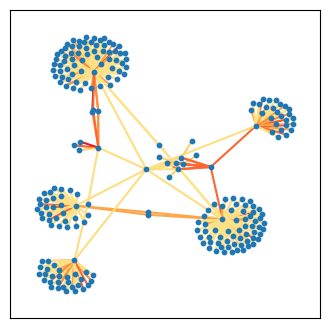

In [ ]:
# Choose nodes for visualization
nodes = data.test_idx.numpy()[:10]
edgelist = []
typelist = []

# Ues NetworkX
G = nx.Graph()
for node in nodes:
    neighbors = data.edge_index[0, (data.edge_index[1] == node)].numpy()
    G.add_node(node)
    for neighbor in neighbors:
        G.add_node(neighbor)
        G.add_edge(neighbor, node)
        edgelist.append((neighbor, node))
        type = data.edge_type[torch.logical_and(data.edge_index[0] == neighbor, data.edge_index[1] == node)].numpy()
        typelist.append(type[0])

# Scale edge type values
scale_min, scale_max = 0.2, 1.0
colorlist = (scale_max - scale_min) / (np.max(typelist) - np.min(typelist)) * (typelist - np.min(typelist)) + scale_min

# Plot
fig, ax = plt.subplots(figsize=(4,4))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=list(G), node_size=10)
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color=colorlist, edge_cmap=plt.cm.YlOrRd,
                        width=1.5, ax=ax, edge_vmin=0, edge_vmax=1)
plt.savefig('10-node-subgraph-1.1.png', dpi=300, bbox_inches='tight')


Augment features:

In [ ]:
augment = "arange" # "arange" or "one-hot"
if augment == "arange":
    data.x = torch.arange(data.num_nodes, dtype=torch.float32)[:, None]
elif augment == "one-hot":
    data.x = torch.eye(data.num_nodes, dtype=torch.float32)
dataset.num_augmented_features = data.x.shape[1]

#### 1.1.2 Random baseline

In [ ]:
def RandomClassifier(pred_len):
    return torch.randint(0, dataset.num_classes, size=(pred_len,))

def eval_random_accuracy(model, eval_y):
    pred = model(eval_y.shape[0])
    correct = pred.eq(eval_y).sum().item()
    total = eval_y.shape[0]
    return correct / total

def use_random():
    # model
    random_model = RandomClassifier

    # test
    accuracy = eval_random_accuracy(random_model, data.test_y)
    return accuracy

num_runs = 100
accuracies = []
for run in range(num_runs):
    # print("### Run: {}".format(run + 1))
    accuracy = use_random()
    accuracies.append(accuracy)
print("Model: Random")
print("Accuracies: {}".format(accuracies))
print("Mean: {}".format(np.mean(accuracies)))
print("Standard deviation: {}".format(np.std(accuracies)))

Model: Random
Accuracies: [0.25, 0.3611111111111111, 0.19444444444444445, 0.3611111111111111, 0.3055555555555556, 0.19444444444444445, 0.3611111111111111, 0.2777777777777778, 0.19444444444444445, 0.2777777777777778, 0.1111111111111111, 0.2222222222222222, 0.2777777777777778, 0.2222222222222222, 0.2777777777777778, 0.1388888888888889, 0.25, 0.25, 0.19444444444444445, 0.3333333333333333, 0.3055555555555556, 0.25, 0.2777777777777778, 0.2777777777777778, 0.3888888888888889, 0.3888888888888889, 0.19444444444444445, 0.2222222222222222, 0.25, 0.3888888888888889, 0.3611111111111111, 0.19444444444444445, 0.1388888888888889, 0.25, 0.2777777777777778, 0.3333333333333333, 0.25, 0.2222222222222222, 0.1111111111111111, 0.19444444444444445, 0.4166666666666667, 0.1388888888888889, 0.19444444444444445, 0.3055555555555556, 0.3055555555555556, 0.16666666666666666, 0.25, 0.25, 0.3611111111111111, 0.25, 0.2777777777777778, 0.3055555555555556, 0.3055555555555556, 0.16666666666666666, 0.3055555555555556, 0.2

#### 1.1.3 Feature baseline

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, node_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.logits = nn.Linear(node_dim, num_classes)

    def forward(self, x):
        return self.logits(x)

    @torch.no_grad()
    def eval_accuracy(self, eval_x, eval_y):
        pred = self(eval_x).max(dim=1)[1]
        correct = pred.eq(eval_y).sum().item()
        total = eval_x.shape[0]
        return correct / total

def use_mlp(seed):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    mlp_model = MLPClassifier(dataset.num_augmented_features, dataset.num_classes)
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01, weight_decay=5e-4)

    # train
    for epoch in range(100):
        mlp_model.train()
        feature, label = data.x[data.train_idx], data.train_y
        pred = mlp_model(feature)
        loss = F.cross_entropy(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # valid
        if (epoch + 1) % 20 == 0:
            accuracy = mlp_model.eval_accuracy(data.x[data.test_idx], data.test_y)
            print("Epoch: {}\tValidation accuracy: {}".format(epoch + 1, accuracy))

    # test
    accuracy = mlp_model.eval_accuracy(data.x[data.test_idx], data.test_y)
    return accuracy

seed_list = [0, 10388, 170001]
num_runs = len(seed_list)
accuracies = []
for run in range(num_runs):
    print("### Run: {}".format(run + 1))
    accuracy = use_mlp(seed=seed_list[run])
    accuracies.append(accuracy)
print("Model: MLP")
print("Accuracies: {}".format(accuracies))
print("Mean: {}".format(np.mean(accuracies)))
print("Standard deviation: {}".format(np.std(accuracies)))

### Run: 1
Epoch: 20	Validation accuracy: 0.16666666666666666
Epoch: 40	Validation accuracy: 0.16666666666666666
Epoch: 60	Validation accuracy: 0.16666666666666666
Epoch: 80	Validation accuracy: 0.3333333333333333
Epoch: 100	Validation accuracy: 0.4166666666666667
### Run: 2
Epoch: 20	Validation accuracy: 0.08333333333333333
Epoch: 40	Validation accuracy: 0.4166666666666667
Epoch: 60	Validation accuracy: 0.4166666666666667
Epoch: 80	Validation accuracy: 0.3333333333333333
Epoch: 100	Validation accuracy: 0.4166666666666667
### Run: 3
Epoch: 20	Validation accuracy: 0.08333333333333333
Epoch: 40	Validation accuracy: 0.16666666666666666
Epoch: 60	Validation accuracy: 0.3333333333333333
Epoch: 80	Validation accuracy: 0.3333333333333333
Epoch: 100	Validation accuracy: 0.16666666666666666
Model: MLP
Accuracies: [0.4166666666666667, 0.4166666666666667, 0.16666666666666666]
Mean: 0.3333333333333333
Standard deviation: 0.11785113019775793


#### 1.1.4 GNN

In [ ]:
class GNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_gnn_layers, rgcn=pyg_nn.RGCNConv):
        super(GNNClassifier, self).__init__()
        self.gnn_layers = nn.ModuleList()
        self.gnn_layers.append(rgcn(input_dim, hidden_dim, dataset.num_relations))
        for _ in range(num_gnn_layers - 1):
            self.gnn_layers.append(rgcn(hidden_dim, hidden_dim, dataset.num_relations))
        self.logits = nn.Linear(hidden_dim, num_classes)

    def forward(self, edge_index, edge_type):
        for i, layer in enumerate(self.gnn_layers):
            if i == 0:
                x = layer(None, edge_index, edge_type)
            else:
                x = layer(x, edge_index, edge_type)
            if i < len(self.gnn_layers) - 1:
                x = F.relu(x)
        logits = F.log_softmax(self.logits(x), dim=1)
        return logits

    @torch.no_grad()
    def eval_accuracy(self, edge_index, edge_type, eval_idx, eval_label):
        pred = self(edge_index, edge_type).max(dim=1)[1]
        correct = pred[eval_idx].eq(eval_label).sum().item()
        total = eval_idx.shape[0]
        return correct / total

def use_gnn(seed, hidden_dim, num_gnn_layers):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    gnn_model = GNNClassifier(input_dim=data.num_nodes,
                              hidden_dim=hidden_dim,
                              num_classes=dataset.num_classes,
                              num_gnn_layers=num_gnn_layers).to("cuda")
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01, weight_decay=0)

    # data
    x, edge_index, edge_type = data.x.to("cuda"), data.edge_index.to("cuda"), data.edge_type.to("cuda")
    train_y, train_idx, test_y, test_idx = data.train_y.to("cuda"), data.train_idx, data.test_y.to("cuda"), data.test_idx

    # train
    for epoch in range(50):
        gnn_model.train()
        pred = gnn_model(edge_index, edge_type)
        loss = F.nll_loss(pred[train_idx], train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # valid
        if (epoch + 1) % 10 == 0:
            accuracy = gnn_model.eval_accuracy(edge_index, edge_type, test_idx, test_y)
            print("Epoch: {}\tValidation accuracy: {}".format(epoch + 1, accuracy))

    # test
    accuracy = gnn_model.eval_accuracy(edge_index, edge_type, test_idx, test_y)
    return accuracy

In [ ]:
seed_list = [42, 10492, 114514]
num_runs = len(seed_list)
accuracies = []
for run in range(num_runs):
    print("### Run: {}".format(run + 1))
    accuracy = use_gnn(seed=seed_list[run], hidden_dim=8, num_gnn_layers=2)
    accuracies.append(accuracy)
print("Model: GNN")
print("Accuracies: {}".format(accuracies))
print("Mean: {}".format(np.mean(accuracies)))
print("Standard deviation: {}".format(np.std(accuracies)))

### Run: 1
Epoch: 10	Validation accuracy: 0.9444444444444444
Epoch: 20	Validation accuracy: 0.9722222222222222
Epoch: 30	Validation accuracy: 0.9722222222222222
Epoch: 40	Validation accuracy: 0.9722222222222222
Epoch: 50	Validation accuracy: 0.9722222222222222
### Run: 2
Epoch: 10	Validation accuracy: 0.9722222222222222
Epoch: 20	Validation accuracy: 0.9722222222222222
Epoch: 30	Validation accuracy: 0.9722222222222222
Epoch: 40	Validation accuracy: 0.9722222222222222
Epoch: 50	Validation accuracy: 0.9722222222222222
### Run: 3
Epoch: 10	Validation accuracy: 0.9166666666666666
Epoch: 20	Validation accuracy: 0.9166666666666666
Epoch: 30	Validation accuracy: 0.9166666666666666
Epoch: 40	Validation accuracy: 0.9166666666666666
Epoch: 50	Validation accuracy: 0.9166666666666666
Model: GNN
Accuracies: [0.9722222222222222, 0.9722222222222222, 0.9166666666666666]
Mean: 0.9537037037037037
Standard deviation: 0.026189140043946214


#### 1.1.5 Oversmoothing

Model depth exploration

In [ ]:
num_gnn_layers_list = [2, 5, 10, 20, 40, 80]
num_runs = len(num_gnn_layers_list)
depth_accuracies = []
for run in range(num_runs):
    print("### Depth: {}".format(num_gnn_layers_list[run]))
    accuracy = use_gnn(seed=42, hidden_dim=8, num_gnn_layers=num_gnn_layers_list[run])
    depth_accuracies.append(accuracy)
print("Model depth exploration: ")
print("Accuracies: {}".format(depth_accuracies))

### Depth: 2
Epoch: 10	Validation accuracy: 0.9444444444444444
Epoch: 20	Validation accuracy: 0.9722222222222222
Epoch: 30	Validation accuracy: 0.9722222222222222
Epoch: 40	Validation accuracy: 0.9722222222222222
Epoch: 50	Validation accuracy: 0.9722222222222222
### Depth: 5
Epoch: 10	Validation accuracy: 0.9444444444444444
Epoch: 20	Validation accuracy: 0.9166666666666666
Epoch: 30	Validation accuracy: 0.8888888888888888
Epoch: 40	Validation accuracy: 0.8888888888888888
Epoch: 50	Validation accuracy: 0.8888888888888888
### Depth: 10
Epoch: 10	Validation accuracy: 0.8333333333333334
Epoch: 20	Validation accuracy: 0.8888888888888888
Epoch: 30	Validation accuracy: 0.9166666666666666
Epoch: 40	Validation accuracy: 0.9166666666666666
Epoch: 50	Validation accuracy: 0.8888888888888888
### Depth: 20
Epoch: 10	Validation accuracy: 0.6388888888888888
Epoch: 20	Validation accuracy: 0.7777777777777778
Epoch: 30	Validation accuracy: 0.8055555555555556
Epoch: 40	Validation accuracy: 0.8333333333333

Model width exploration

In [ ]:
hidden_dim_list = [4, 8, 16, 32, 64, 128]
num_runs = len(hidden_dim_list)
width_accuracies = []
for run in range(num_runs):
    print("### Width: {}".format(hidden_dim_list[run]))
    accuracy = use_gnn(seed=42, hidden_dim=hidden_dim_list[run], num_gnn_layers=2)
    width_accuracies.append(accuracy)
print("Model width exploration: ")
print("Accuracies: {}".format(width_accuracies))

### Width: 4
Epoch: 10	Validation accuracy: 0.8611111111111112
Epoch: 20	Validation accuracy: 0.9722222222222222
Epoch: 30	Validation accuracy: 0.9722222222222222
Epoch: 40	Validation accuracy: 0.9722222222222222
Epoch: 50	Validation accuracy: 0.9444444444444444
### Width: 8
Epoch: 10	Validation accuracy: 0.9444444444444444
Epoch: 20	Validation accuracy: 0.9722222222222222
Epoch: 30	Validation accuracy: 0.9722222222222222
Epoch: 40	Validation accuracy: 0.9722222222222222
Epoch: 50	Validation accuracy: 0.9722222222222222
### Width: 16
Epoch: 10	Validation accuracy: 0.9444444444444444
Epoch: 20	Validation accuracy: 0.9722222222222222
Epoch: 30	Validation accuracy: 0.9722222222222222
Epoch: 40	Validation accuracy: 0.9722222222222222
Epoch: 50	Validation accuracy: 0.9722222222222222
### Width: 32
Epoch: 10	Validation accuracy: 0.9722222222222222
Epoch: 20	Validation accuracy: 0.8888888888888888
Epoch: 30	Validation accuracy: 0.8888888888888888
Epoch: 40	Validation accuracy: 0.8888888888888

1. Plot of accuracies vs. model depth
2. Plot of accuracies vs. model width


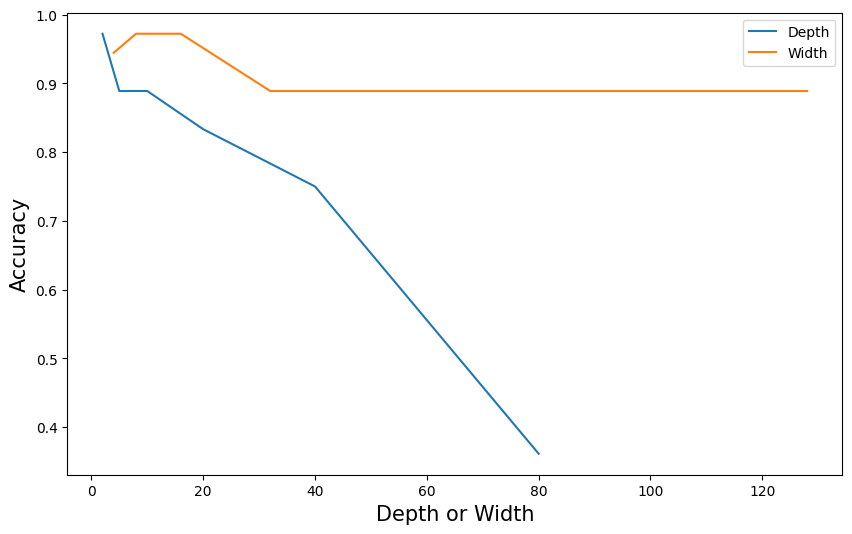

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(num_gnn_layers_list, depth_accuracies, label="Depth")
plt.plot(hidden_dim_list, width_accuracies, label="Width")
plt.xlabel("Depth or Width", size=15)
plt.ylabel("Accuracy", size=15)
plt.savefig('depth or width-acc.eps', dpi=300, bbox_inches='tight')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.savefig('width-acc.eps', dpi=300, bbox_inches='tight')

Compute oversmoothing metrics.
There are several ways that we could explore to overcome over-smoothing:
1. Normalizing and Regularization: (PairNorm-GCN), L2-Regularizer (GCN-L2Reg)
2. Residual Connections (Residual-GCN)


In [ ]:
class OversmoothGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_gnn_layers, rgcn=pyg_nn.RGCNConv, pn=pyg_nn.PairNorm,
                 use_pair_norm=False, use_residual=False):
        super(OversmoothGNN, self).__init__()
        self.gnn_layers = nn.ModuleList()
        self.gnn_layers.append(rgcn(input_dim, hidden_dim, dataset.num_relations, num_bases=10, bias=False))
        self.norms = nn.ModuleList()
        self.norms.append(pn())
        for _ in range(num_gnn_layers - 1):
            self.gnn_layers.append(rgcn(hidden_dim, hidden_dim, dataset.num_relations, num_bases=10, bias=False))
            self.norms.append(pn())
        self.logits = nn.Linear(hidden_dim, num_classes)
        self.use_pair_norm = use_pair_norm
        self.use_residual = use_residual

    def forward(self, edge_index, edge_type):
        x_latents = []
        for i, layer in enumerate(self.gnn_layers):
            # Pass RGCN layer
            if i == 0:
                x_layer = layer(None, edge_index, edge_type)
            else:
                x_layer = layer(x, edge_index, edge_type)

            # Store features for evaluating oversmoothing
            x_latents.append(x_layer.detach())

            # Use PairNorm
            if self.use_pair_norm:
                x_layer = self.norms[i](x_layer)

            # Pass activation layer
            if i < len(self.gnn_layers) - 1:
                x_layer = F.relu(x_layer)

            # Use residual connection
            if self.use_residual:
                if i == 0:
                    x = x_layer
                else:
                    x = x + x_layer
            else:
                x = x_layer

        logits = F.log_softmax(self.logits(x), dim=1)
        return (logits, x_latents)

    @torch.no_grad()
    def eval_accuracy(self, edge_index, edge_type, eval_idx, eval_label):
        pred, _ = self(edge_index, edge_type)
        pred = pred.max(dim=1)[1]
        correct = pred[eval_idx].eq(eval_label).sum().item()
        total = eval_idx.shape[0]
        return correct / total

    @torch.no_grad()
    def dirichlet_energy(self, x, edge_index):
        A = torch_geometric.utils.to_dense_adj(edge_index)
        D = torch.diag(torch.sum(A, axis=1))
        L = D - A
        d_e = torch.matmul(torch.matmul(x.T, L), x).squeeze(0)
        energy = torch.trace(d_e)
        return energy

    @torch.no_grad()
    def eval_oversmoothing(self, edge_index, edge_type):
        _, x_latents = self(edge_index, edge_type)
        d_energies = np.array([self.dirichlet_energy(x, edge_index).cpu() for x in x_latents], np.float64)
        d_energies_log = np.log10(d_energies)
        return d_energies_log

def use_gnn(seed, hidden_dim, num_gnn_layers, use_pair_norm=False, use_reg=False, use_residual=False):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    gnn_model = OversmoothGNN(input_dim=data.num_nodes,
                              hidden_dim=hidden_dim,
                              num_classes=dataset.num_classes,
                              num_gnn_layers=num_gnn_layers,
                              use_pair_norm=use_pair_norm,
                              use_residual=use_residual).to("cuda")
    if use_reg:
        optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01, weight_decay=5e-4)
    else:
        optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01, weight_decay=0)

    # data
    x, edge_index, edge_type = data.x.to("cuda"), data.edge_index.to("cuda"), data.edge_type.to("cuda")
    train_y, train_idx, test_y, test_idx = data.train_y.to("cuda"), data.train_idx, data.test_y.to("cuda"), data.test_idx

    # train
    for epoch in range(50):
        gnn_model.train()
        pred, _ = gnn_model(edge_index, edge_type)
        loss = F.nll_loss(pred[train_idx], train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # valid
        if (epoch + 1) % 10 == 0:
            accuracy = gnn_model.eval_accuracy(edge_index, edge_type, test_idx, test_y)
            print("Epoch: {}\tValidation accuracy: {}".format(epoch + 1, accuracy))

    # test
    accuracy = gnn_model.eval_accuracy(edge_index, edge_type, test_idx, test_y)
    print("Test accuracy: {}".format(accuracy))

    # oversmoothing
    log_d_energies = gnn_model.eval_oversmoothing(edge_index, edge_type)
    return log_d_energies

energy_baseline = use_gnn(seed=42, hidden_dim=16, num_gnn_layers=80)

Epoch: 10	Validation accuracy: 0.3333333333333333
Epoch: 20	Validation accuracy: 0.3333333333333333
Epoch: 30	Validation accuracy: 0.3333333333333333
Epoch: 40	Validation accuracy: 0.4166666666666667
Epoch: 50	Validation accuracy: 0.4166666666666667
Test accuracy: 0.4166666666666667


In [ ]:
energy_with_pn = use_gnn(seed=42, hidden_dim=16, num_gnn_layers=80, use_pair_norm=True)

Epoch: 10	Validation accuracy: 0.6666666666666666
Epoch: 20	Validation accuracy: 0.8888888888888888
Epoch: 30	Validation accuracy: 0.9166666666666666
Epoch: 40	Validation accuracy: 0.9166666666666666
Epoch: 50	Validation accuracy: 0.9166666666666666
Test accuracy: 0.9166666666666666


In [ ]:
energy_with_reg = use_gnn(seed=42, hidden_dim=16, num_gnn_layers=80, use_reg=True)

Epoch: 10	Validation accuracy: 0.3333333333333333
Epoch: 20	Validation accuracy: 0.3333333333333333
Epoch: 30	Validation accuracy: 0.3333333333333333
Epoch: 40	Validation accuracy: 0.4166666666666667
Epoch: 50	Validation accuracy: 0.4166666666666667
Test accuracy: 0.4166666666666667


In [ ]:
energy_with_residual = use_gnn(seed=42, hidden_dim=16, num_gnn_layers=80, use_residual=True)

Epoch: 10	Validation accuracy: 0.4166666666666667
Epoch: 20	Validation accuracy: 0.4166666666666667
Epoch: 30	Validation accuracy: 0.4166666666666667
Epoch: 40	Validation accuracy: 0.4166666666666667
Epoch: 50	Validation accuracy: 0.4166666666666667
Test accuracy: 0.4166666666666667


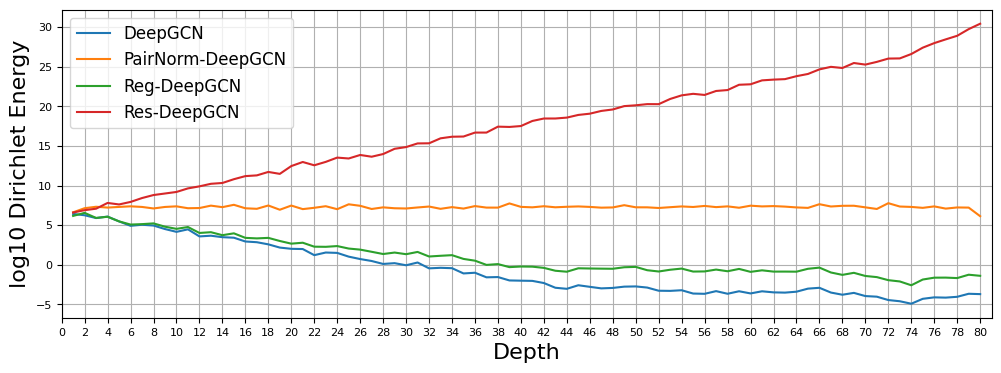

In [ ]:
num_gnn_layers = 80
x = np.arange(1, num_gnn_layers+1)

plt.figure(figsize=(12, 4))
plt.plot(x, energy_baseline, label="DeepGCN")
plt.plot(x, energy_with_pn, label="PairNorm-DeepGCN")
plt.plot(x, energy_with_reg, label="Reg-DeepGCN")
plt.plot(x, energy_with_residual, label="Res-DeepGCN")
plt.xticks(np.arange(0, num_gnn_layers+1, 2), fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0, np.max(x)+1)
plt.xlabel("Depth", fontsize=16)
plt.ylabel("log10 Dirichlet Energy", fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.savefig('oversmooth.eps', dpi=300, bbox_inches='tight')

In [ ]:
# energy_with_reg